In [5]:
# Import relevant libraries
import matplotlib.pyplot as plt
import mne
from mnelab.io import read_raw
import numpy as np
import pyxdf
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import os
import yaml

sns.set_context("paper", font_scale=1.5)


In [6]:
def replace_with_fixation(data:tuple, idx:list, window:float, fixation:float):
    """
    Replaces the window around the outlier position with the fixation point on the screen

    Args:
        data (tuple): time series data for a specific coordinate (x or y)
        idx (list): indices of outlier positions
        window (float): duration in time in which values are replaced by fixation
        fixation (float): fixation point on the screen (mid point of the monitor depending on the resolution, for example: 1920/2,1080/2)

    Returns:
        _type_: _description_
    """
    n_samples = len(data)

    idx_shift = np.roll(idx, shift=1, axis=0)
    idx_shift[0] = False
    starts = np.where(idx & ~idx_shift)[0]
    ends = np.where(~idx & idx_shift)[0]
    if idx[-1] == True:
         ends = np.append(ends, n_samples)
    for i_missed in range(starts.size):
        start_idx = np.max(np.array([0, starts[i_missed] - window])).astype(int)
        end_idx = np.min(np.array([ends[i_missed] + window, n_samples])).astype(int)
        data[start_idx:end_idx] = fixation
    return data


def minimal_preprocessing(data:np.ndarray, fs):
    """
    Corrects coordinates of the eyetracking data

    Args:
        data (np.ndarray): eyelink markerstream

    Returns:
        np.ndarray: corrected time_series of the eyelink markerstream
    """
    for column in np.arange(4): # columns containing data about position                
        # x-coordinates
        if column ==0 or column ==2:   
          idx_1 = data['time_series'][:,column] < 0 # find points less than 0
          data['time_series'][idx_1,column] = -data['time_series'][idx_1,column] # force values to be positive
          
          # replace values greater than resolution limit by fixation 
          idx_2 = data['time_series'][:,column] > 1920 
          data['time_series'][:, column] = replace_with_fixation(data=data['time_series'][:, column],idx=idx_2,window=np.rint(fs*0.1),fixation=1920/2) 
          
        # y coordinates
        elif column == 1 or column == 3:          
          idx_1 = data['time_series'][:,column] < 0 # find points less than 0
          data['time_series'][idx_1,column] = -data['time_series'][idx_1,column]
          
          idx_2 = data['time_series'][:,column] > 1080  
          data['time_series'][:, column] = replace_with_fixation(data=data['time_series'][:, column],idx=idx_2,window=np.rint(fs*0.1),fixation=1080/2) 
          
    
    return data['time_series']
  
def find_eyelink_trial_onsets(eyelink_stream: np.ndarray, lsl_stream: np.ndarray):
  """
  Finds the indices of the corresponding trial onset times for eyelink data from the lsl markerstream

  Args:
      eyelink_stream (np.ndarray): eyelink marker stream
      lsl_stream (np.ndarray): lsl markerstream

  Returns:
      np.array: indices corresponding to the eyelink trial onsets
  """
  
  # get epoched eyelink data across all runs
  # offsets and corrected timestamps
  offset_lsl = lsl_stream['time_stamps'][0]
  offset_eyelink = eyelink_stream['time_stamps'][0]

  # correct eyelink timestamps 
  eyelink_times_corr = eyelink_stream['time_stamps'] - offset_eyelink

  lsl_trial_onsets = [timestamp - offset_lsl for timestamp, marker in zip(lsl_stream['time_stamps'], lsl_stream['time_series']) if marker[2]=='start_trial']

  # find indices of closest timestamps of eyelink stream to the lsl trial onsets
  matching_eyelink_ind = np.zeros(len(lsl_trial_onsets,))

  for index, onset_time in enumerate(lsl_trial_onsets):
      # find the difference between the lsl onsets and the eyelink timestamps
      diff_i  = np.abs(onset_time - eyelink_times_corr) 
          
      # select the eyelink timestamp index with the minimum absolute difference
      matching_eyelink_ind[index] = np.argmin(diff_i)

  matching_eyelink_ind = matching_eyelink_ind.astype(int)

  return matching_eyelink_ind  
    

In [26]:
# Participant information and parameters of the pilot study

# Participant info
project_path = r'C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2'

# load relevant parameters
with open(os.path.join(project_path,'config.yml'), "r") as yaml_file:
    config_data = yaml.safe_load(yaml_file)
    
analysis_params = config_data['analysis_params']
experimental_params = config_data['experimental_params']

n_trials = experimental_params['N_TRIALS']
trial_time = experimental_params['TRIAL_TIME']

n_channels = analysis_params['N_CHANNELS']
fs = 713 # downsampled frequency
n_subjects = analysis_params['N_SUBJECTS']
n_runs_ov = analysis_params['N_RUNS_OVERT'] # number of runs in the overt condition
n_runs_cov = analysis_params['N_RUNS_COVERT']

# loading paths
data_path =r'C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data'

# preprocessed eeg data filenames of all subjects
subjects_overt = ["Pilot2","Pilot3","Pilot4"]
subjects_covert = subjects_overt


# Set conditions for the notebook
condition = 'covert'
if condition == 'covert':
    # trial_time_samples = fs * trial_time
    trial_time_samples = fs * trial_time
    total_trials = n_trials * n_runs_cov
    n_runs = n_runs_cov
else:
    trial_time_samples = fs * trial_time
    total_trials = n_trials * n_runs_ov
    n_runs = n_runs_ov
    
n_chans = 6 # 6 channels in eye tracking data

In [27]:
epo_data_all_subjects = np.zeros((len(subjects_covert), total_trials, n_chans, trial_time_samples))
labels_all_subjects = np.zeros((len(subjects_covert),total_trials))

print(f"shape of epoched data for all subjects, condition: {condition}", epo_data_all_subjects.shape)

ses =  "ses-S001"
for i_sub, subject in enumerate(subjects_covert):
  epo_data_all_runs = []
  labels_all_runs = []
  print("subject", i_sub+1)
  
  for i_run in range(n_runs):
      
    print("run", i_run)
    fn = os.path.join(data_path, "raw", f"sub-{subject}", ses, "eeg", 
                        f"sub-{subject}_{ses}_task-{condition}_run-{1+i_run:03d}_eeg.xdf")
    
    data, header = pyxdf.load_xdf(fn)

    # get eyelink and lsl data
    streams = pyxdf.load_xdf(fn)[0]
    names = [stream["info"]["name"][0] for stream in streams]
    
    marker_stream_lsl = streams[names.index("KeyboardMarkerStream")]
    marker_stream_eyelink = streams[names.index("EyeLink")]
    
    # use labels to differentiate trials                        
    labels = [marker[3].lower().strip('""') == "right" 
    for marker in marker_stream_lsl["time_series"]
    if marker[2] == "cued_side"]
    labels_all_runs.append([1 if label else 0 for label in labels])
    
    # minimal preprocessing for eyelink data
    eyelink_vals_corr = minimal_preprocessing(data = marker_stream_eyelink, fs = fs) # corrected coordinates for x and y axes          
    
    # get eyelink trial onset indices from lsl marker stream
    matching_eyelink_ind = find_eyelink_trial_onsets(eyelink_stream=marker_stream_eyelink, lsl_stream=marker_stream_lsl)        
    
    eyelink_vals_corr = eyelink_vals_corr.transpose([1,0]) # channels x samples   
    
    # epoch data using the trial onset indices found 
    epo_data_run_i = np.array([[eyelink_vals_corr[i][j:j+trial_time_samples] 
        for j in matching_eyelink_ind] for i in range(6)]).transpose([1,0,2])

    epo_data_all_runs.append(epo_data_run_i)

    
  epo_data_all_runs = np.array(epo_data_all_runs)        
  epo_data_all_runs = np.array(epo_data_all_runs).reshape(epo_data_all_runs.shape[0]*epo_data_all_runs.shape[1], epo_data_all_runs.shape[2], epo_data_all_runs.shape[3])
  labels_all_runs = np.array(labels_all_runs)
  labels_all_runs = labels_all_runs.reshape(labels_all_runs.shape[0]*labels_all_runs.shape[1],)
  
  epo_data_all_subjects[i_sub] = epo_data_all_runs 
  labels_all_subjects[i_sub] = np.array(labels_all_runs) 
  print("finished for subject", i_sub+2)

shape of epoched data for all subjects, condition: covert (3, 80, 6, 14260)
subject 1
run 0
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot2\ses-S001\eeg\sub-Pilot2_ses-S001_task-covert_run-001_eeg.xdf


Stream 3: Calculated effective sampling rate 728.3559 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 728.3559 Hz is different from specified rate 1000.0000 Hz.


run 1
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot2\ses-S001\eeg\sub-Pilot2_ses-S001_task-covert_run-002_eeg.xdf


Stream 3: Calculated effective sampling rate 731.1331 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 731.1331 Hz is different from specified rate 1000.0000 Hz.


run 2
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot2\ses-S001\eeg\sub-Pilot2_ses-S001_task-covert_run-003_eeg.xdf


Stream 3: Calculated effective sampling rate 725.0047 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 725.0047 Hz is different from specified rate 1000.0000 Hz.


run 3
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot2\ses-S001\eeg\sub-Pilot2_ses-S001_task-covert_run-004_eeg.xdf


Stream 2: Calculated effective sampling rate 722.2294 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 722.2294 Hz is different from specified rate 1000.0000 Hz.


finished for subject 2
subject 2
run 0
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot3\ses-S001\eeg\sub-Pilot3_ses-S001_task-covert_run-001_eeg.xdf


Stream 2: Calculated effective sampling rate 729.4612 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 729.4612 Hz is different from specified rate 1000.0000 Hz.


run 1
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot3\ses-S001\eeg\sub-Pilot3_ses-S001_task-covert_run-002_eeg.xdf


Stream 2: Calculated effective sampling rate 728.9539 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 728.9539 Hz is different from specified rate 1000.0000 Hz.


run 2
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot3\ses-S001\eeg\sub-Pilot3_ses-S001_task-covert_run-003_eeg.xdf


Stream 2: Calculated effective sampling rate 730.0779 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 730.0779 Hz is different from specified rate 1000.0000 Hz.


run 3
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot3\ses-S001\eeg\sub-Pilot3_ses-S001_task-covert_run-004_eeg.xdf


Stream 2: Calculated effective sampling rate 729.2770 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 729.2770 Hz is different from specified rate 1000.0000 Hz.


finished for subject 3
subject 3
run 0
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot4\ses-S001\eeg\sub-Pilot4_ses-S001_task-covert_run-001_eeg.xdf


Stream 1: Calculated effective sampling rate 734.6875 Hz is different from specified rate 1000.0000 Hz.
Stream 1: Calculated effective sampling rate 734.6875 Hz is different from specified rate 1000.0000 Hz.


run 1
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot4\ses-S001\eeg\sub-Pilot4_ses-S001_task-covert_run-002_eeg.xdf


Stream 1: Calculated effective sampling rate 734.4605 Hz is different from specified rate 1000.0000 Hz.
Stream 1: Calculated effective sampling rate 734.4605 Hz is different from specified rate 1000.0000 Hz.


run 2
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot4\ses-S001\eeg\sub-Pilot4_ses-S001_task-covert_run-003_eeg.xdf


Stream 1: Calculated effective sampling rate 732.2591 Hz is different from specified rate 1000.0000 Hz.
Stream 1: Calculated effective sampling rate 732.2591 Hz is different from specified rate 1000.0000 Hz.


run 3
C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\version_2\experiment_version_2\data\raw\sub-Pilot4\ses-S001\eeg\sub-Pilot4_ses-S001_task-covert_run-004_eeg.xdf


Stream 2: Calculated effective sampling rate 735.1801 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 735.1801 Hz is different from specified rate 1000.0000 Hz.


finished for subject 4


In [28]:
print(epo_data_all_subjects.shape, "(subjects x trials x channels x samples)")
print(labels_all_subjects.shape,"subjects x trial labels")

(3, 80, 6, 14260) (subjects x trials x channels x samples)
(3, 80) subjects x trial labels


(80, 6, 14260)
(80, 6, 14260)
(80, 6, 14260)


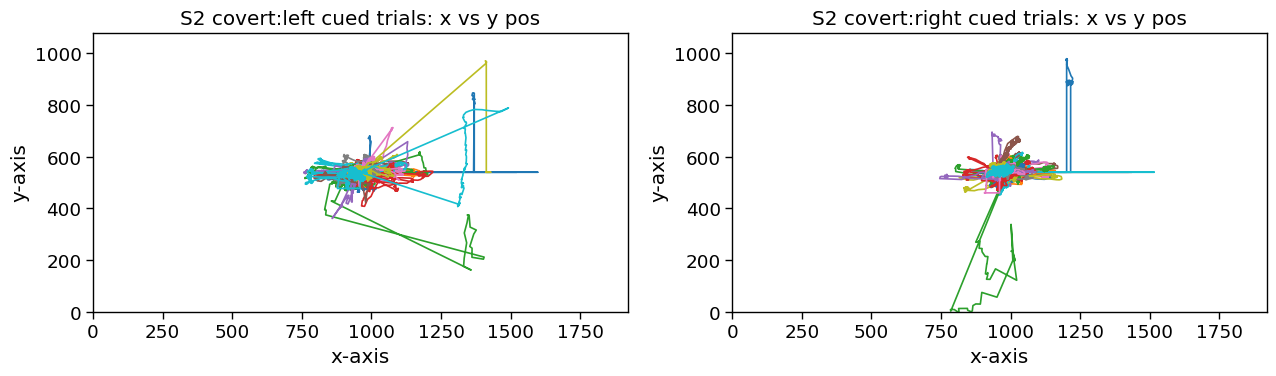

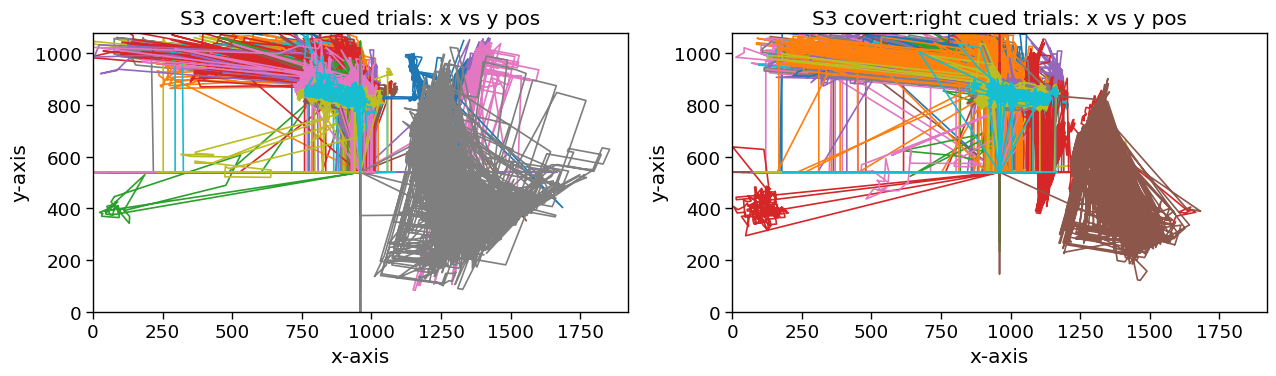

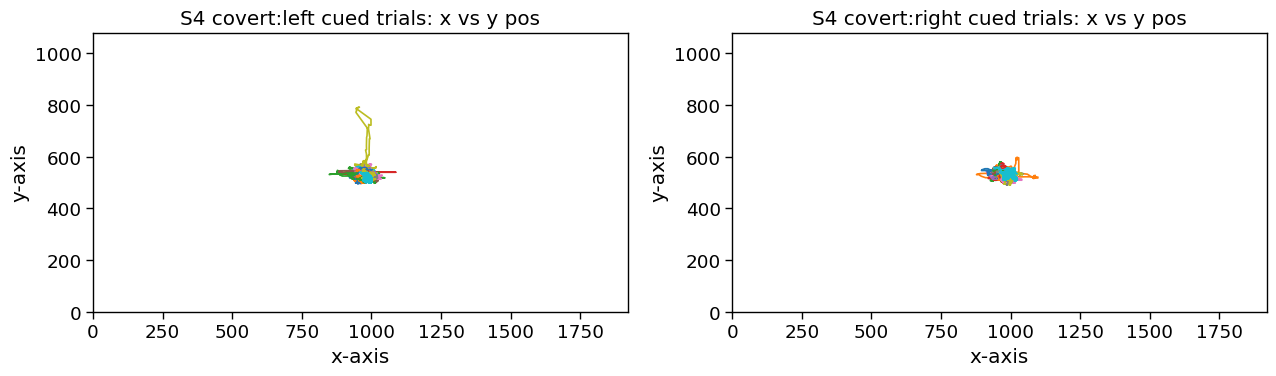

In [29]:
for i_sub in range(len(subjects_covert)):
    
    # get data
    X, y = epo_data_all_subjects[i_sub], labels_all_subjects[i_sub]
    # trial_chosen = 1
    print(X.shape)

    # plot eye tracking data for different classes

    # pick a random run here
    data_class0 = X[np.where(y == 0)[0]]
    data_class1 = X[np.where(y == 1)[0]]
    
    plt.figure(figsize = (13,4))
    plt.subplot(121)
    for trial_chosen in range(data_class0.shape[0]):
        plt.plot(data_class0[trial_chosen][0],data_class0[trial_chosen][1])
    plt.xlim([0,1920])
    plt.ylim([0,1080])
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title(f'S{i_sub+2} {condition}:left cued trials: x vs y pos')

    plt.subplot(122)
    for trial_chosen in range(data_class1.shape[0]):
        plt.plot(data_class1[trial_chosen][0],data_class1[trial_chosen][1])
    plt.xlim([0,1920])
    plt.ylim([0,1080])
    plt.title(f'S{i_sub+2} {condition}:right cued trials: x vs y pos')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.tight_layout()

mean accuracy across folds for all subjects [0.8125 0.725  0.575 ]
mean accuracy across folds and all subjects 0.7041666666666667


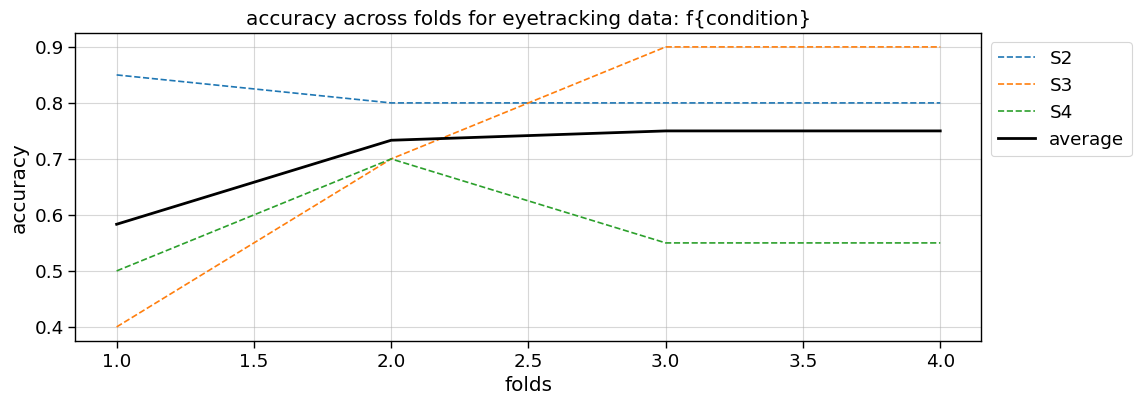

In [32]:
# fit the data to a classifier
# evaluating performance across participants
n_folds = 4
accuracy_covert = np.zeros((len(subjects_covert), n_folds)) 


for i_sub in range(len(subjects_covert)):
    X, y = epo_data_all_subjects[i_sub], labels_all_subjects[i_sub]
    
    n_trials, n_channels, n_samples = X.shape
    n_classes = len(np.unique(y))
    

    folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

    # Loop folds
    accuracy = np.zeros(n_folds)
    for i_fold in range(n_folds):
        # Split data to train and test set
        X_trn, y_trn = X[folds != i_fold, :, :n_samples].mean(axis=2), y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold, :, :n_samples].mean(axis=2), y[folds == i_fold]

        # fit data 
        'average the time dimension, take windows'
        clf = LDA()
        clf.fit(X_trn,y_trn)

        # Apply template-matching classifier
        yh_tst = clf.predict(X_tst)

        # Compute accuracy
        accuracy[i_fold] = np.mean(yh_tst == y_tst)
        
    accuracy_covert[i_sub] = accuracy

plt.figure(figsize = (11.69,4))        
for i in range(accuracy_covert.shape[0]):
    plt.plot(np.arange(1,5),accuracy_covert[i], label =f'S{i+2}', linestyle = '--')
    
plt.plot(np.arange(1,5), accuracy_covert.mean(axis = 0), color = 'k', linewidth = 2, label = 'average')
plt.xlabel('folds')
plt.ylabel('accuracy')
plt.title('accuracy across folds for eyetracking data: f{condition}')
plt.legend(bbox_to_anchor=(1,1))
plt.grid(alpha = 0.5)

print("mean accuracy across folds for all subjects",accuracy_covert.mean(axis=1))
print("mean accuracy across folds and all subjects",accuracy_covert.mean(axis=0).mean())
              
              

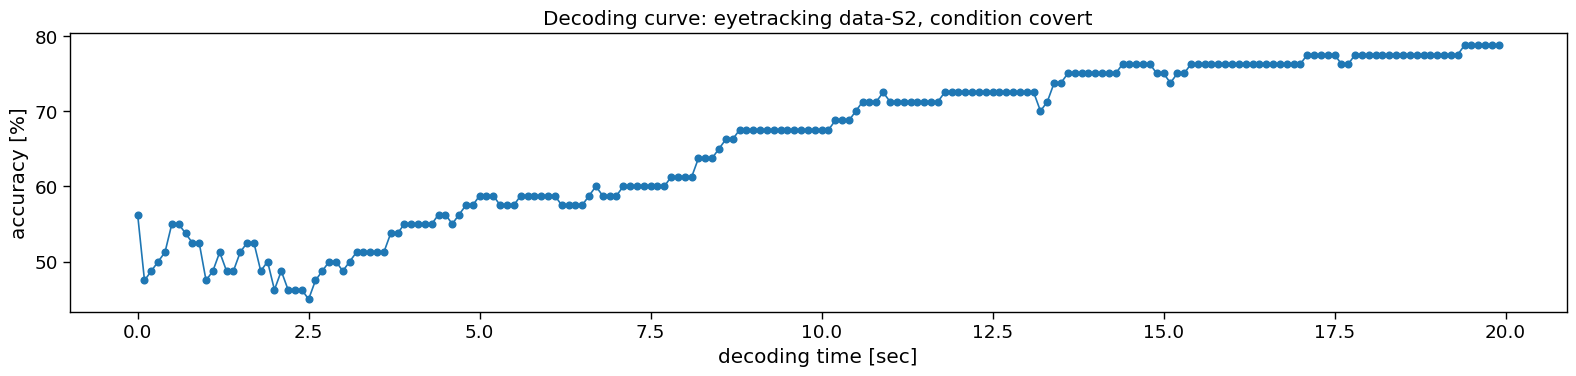

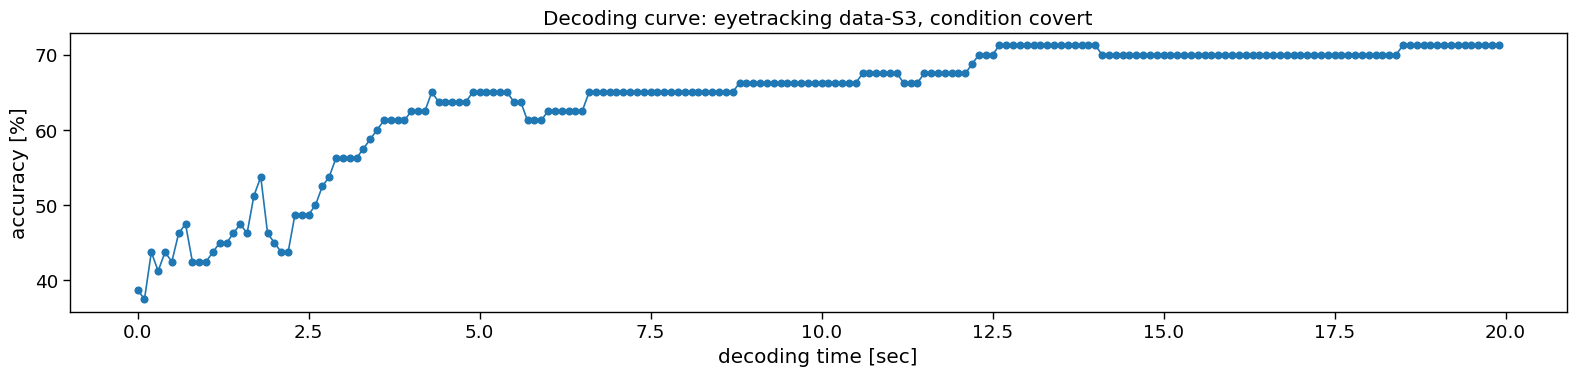

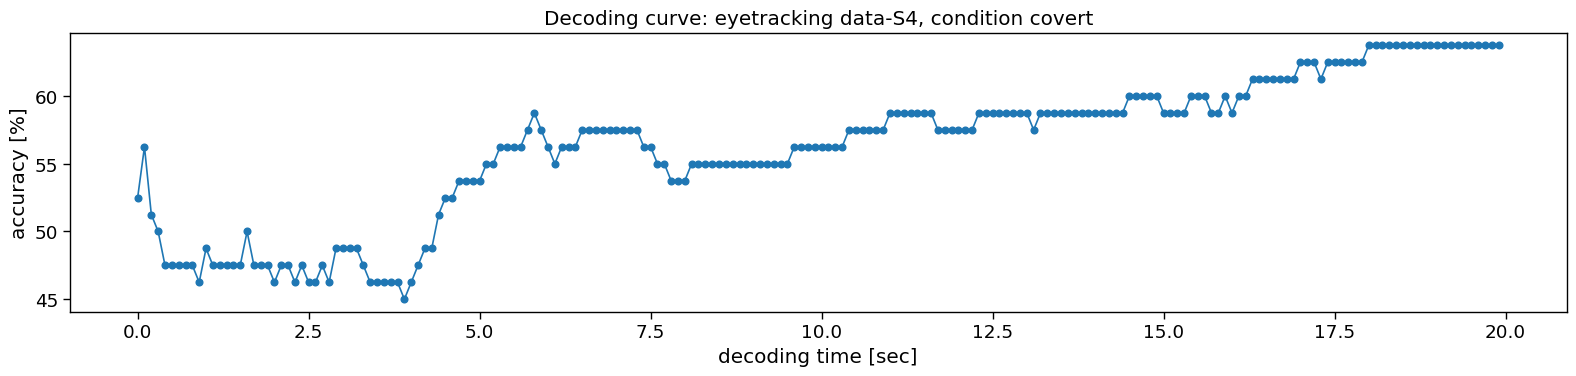

: 

In [33]:
# adding decoding curve
# Set trial duration
trialtime = 20
intertrialtime = 1.0
n_samples = int(trialtime * fs)

# Set decoding curve step size
segment_size = 0.1
n_segments = int(np.floor(n_samples / (segment_size * fs)))




for i_sub in range(len(subjects_covert)):
    
    X, y = epo_data_all_subjects[i_sub], labels_all_subjects[i_sub]
    
    n_trials = X.shape[0]
    # Split data to train and test set
    n_folds = 10
    folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))
    
    accuracy = np.zeros((n_folds, n_segments))
    for i_fold in range(n_folds):

        X_trn, y_trn = X[folds != i_fold, :, :].mean(axis=2), y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold, :, :].mean(axis=2), y[folds == i_fold]

        # Setup classifier
        clf = LDA()
        clf.fit(X_trn,y_trn)

        # Loop segments
        for i_segment in range(n_segments):

            # Apply classifier
            n_samples = int((1 + i_segment) * segment_size * fs)
            
            # limit data to the number of samples in the segment
            X_tst = X[folds == i_fold, :, :n_samples].mean(axis=2)
            
            yh_tst = clf.predict(X_tst) #X_tst[:, :, :n_samples]
            
            # Compute accuracy
            accuracy[i_fold, i_segment] = 100 * np.mean(yh_tst == y_tst)
            
    time = np.tile(np.arange(0, trialtime, segment_size)[np.newaxis, :], (n_folds, 1))

            
    # Plot results
    plt.figure(figsize = (16,4))
    plt.plot(time[0, :], np.mean(accuracy, axis=0), linestyle='-', marker='o')
    plt.xlabel("decoding time [sec]")
    plt.ylabel("accuracy [%]")
    plt.ylim([0, ])
    plt.title(f"Decoding curve: eyetracking data-S{i_sub + 2}, condition {condition}")
    plt.tight_layout()

